# Importamos Librerías

In [ ]:
!pip install -q seaborn

import pathlib
import os
import h5py
from sys import getsizeof

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive

# Obtenemos los datos
Montamos nuestro Google Drive para acceder a los archivos donde tenemos los datos.
Luego importamos el archivo de datos usando pandas.
Por último eliminamos las columnas que no vamos a utilizar e inspeccionamos el aspecto del dataset.

In [ ]:
drive.mount('/content/drive', force_remount=True)
DATA_HOME=r"/content/drive/MyDrive/Colab\ Notebooks/IAA"
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IAA/historico_30.csv", sep=';', na_values = "?")
dataset = dataset.drop('Unnamed: 0', axis=1)
dataset = dataset.drop('fecha', axis=1)
dataset.tail()

Mounted at /content/drive


,temp_aire,hum_relativa,temp_motor
715,25.2,57.0,59.79
716,25.3,55.0,60.01
717,25.4,54.0,59.58
718,24.9,60.0,60.48
719,22.9,70.0,58.60


## Limpiando los Datos
Eliminamos posibles valores desconocidos del dataset.

In [ ]:
# verificamos si contiene valores desconocidos.
dataset.isna().sum()
# de tener valores desconocidos los eliminaríamos
dataset = dataset.dropna()

## Dividimos el dataset en entrenamiento y prueba
Dividimos el dataset en datos que serán utilizados durante el entrenamiento y datos que serán utilizados al final para evaluar el modelo.

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print("Datos de entrenamiento: %d - Datos de prueba: %d" % (len(train_dataset), len(test_dataset)))

Datos de entrenamiento: 576 - Datos de prueba: 144


## Inspeccionamos la información
Mediante pairplot evaluamos las posibles correlaciones entre las diferentes características de los datos.

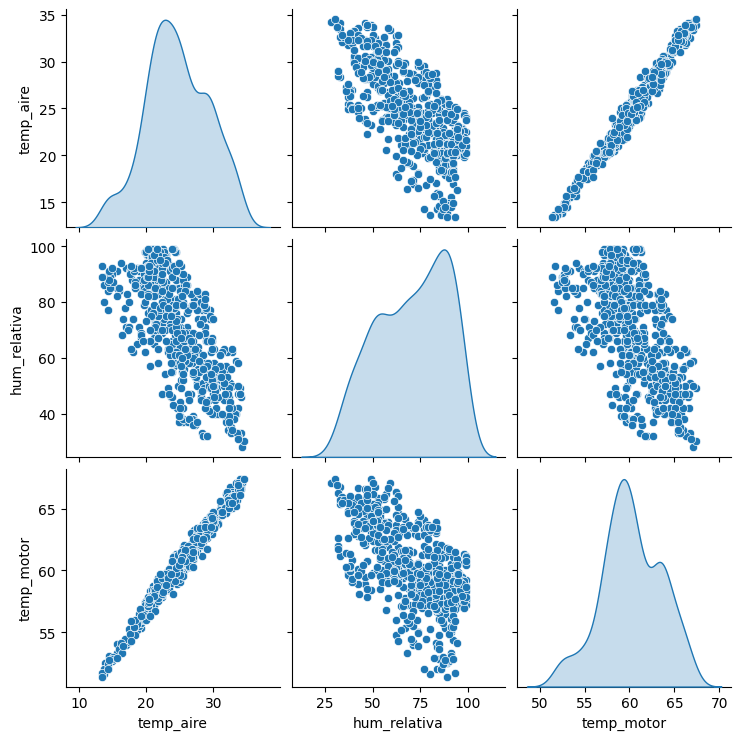

In [ ]:
sns.pairplot(train_dataset[["temp_aire", "hum_relativa", "temp_motor"]], diag_kind="kde")


Y revisamos las diferentes estadísticas de cada una de las variables

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("temp_motor")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
temp_aire,576.0,24.624306,4.629324,13.4,21.6,24.4,28.30,34.5
hum_relativa,576.0,70.460069,18.515943,28.0,55.0,72.0,86.25,99.0


## Separamos características de valor objetivo
Separamos el valor objetivo de las caracteristicas. Este valor objetivo es el valor que entrenará el modelo para predecir.

In [ ]:
train_labels = train_dataset.pop('temp_motor')
test_labels = test_dataset.pop('temp_motor')


## Normalizamos la información
Revisando las [estadísticas](https://colab.research.google.com/drive/1UD-gNO1owYQ2TOW6wExB-u-IU_uAbzTJ#scrollTo=ZtHIyo16dEwv&line=1&uniqifier=1), podemos apreciar que existen diferencias en los rangos de cada característica. Por ejemplo los valores de la temperatura ambiente varían entre los 13 y los 34 grados, mientras que los valores de la humedad varían entre un 28 y un 99 %.

Es una buena práctica normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo * podría * converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante no dependa de la elección de las unidades utilizadas en la entrada.

Nota: Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

Estos datos normalizados es lo que usaremos para entrenar el modelo.

**Precaución:** l*as estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato que se alimente al modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.*

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
#normed_train_data = train_dataset.copy()
#normed_test_data = test_dataset.copy()
#normed_train_data = normed_train_data.drop('temp_motor', axis=1)
#normed_test_data = normed_test_data.drop('temp_motor', axis=1)



# El Modelo
## Construimos el modelo
Empleamos un modelo secuencial con dos capas densamente conectadas y una capa de salida que devolverá un único valor.
Por último inspeccionamos el modelo.

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

Obtenemos una representación gráfica de la estructura del modelo

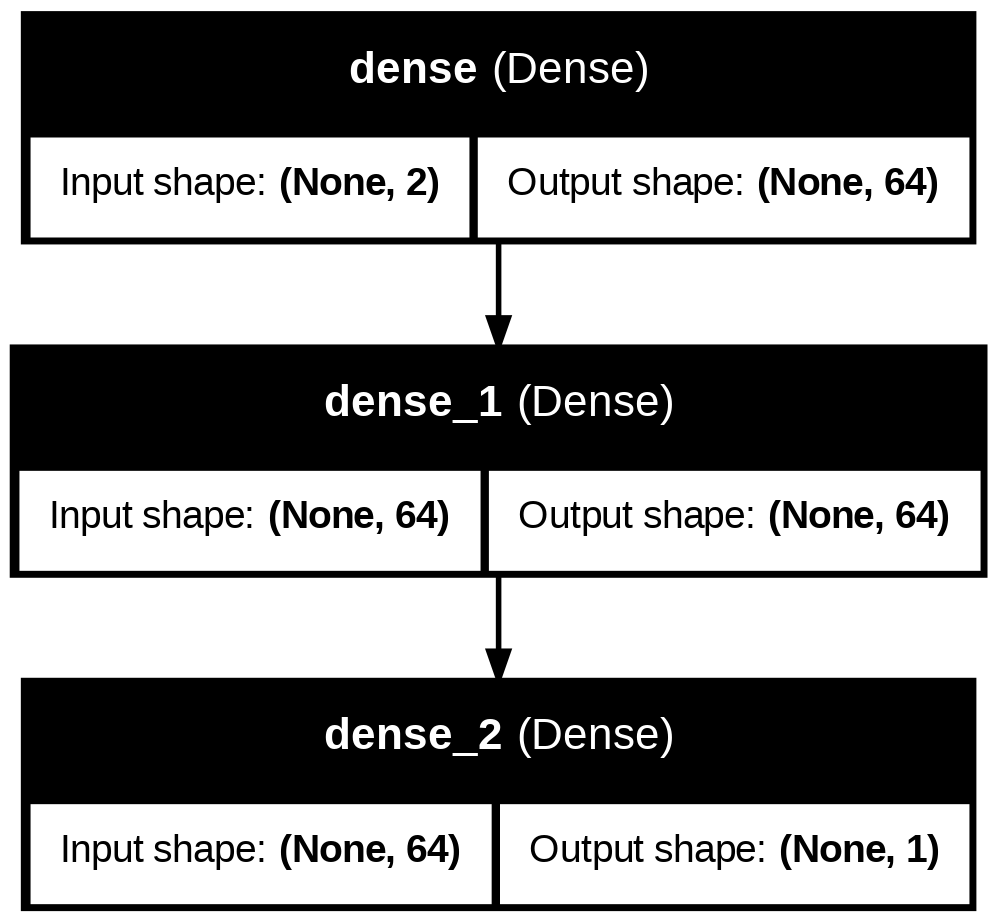

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

Probamos el modelo con algunos datos de ejemplo para ver si produce resultados de la forma y tipo esperados

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


array([[-0.07786864],
       [-0.12261903],
       [-0.11072029],
       [-0.15351333],
       [ 0.01050501],
       [-0.07627233],
       [-0.1714769 ],
       [-0.08403192],
       [ 0.04074782],
       [-0.04079532]], dtype=float32)

## Entrenamos el modelo
Entrenamos el modelo unas 200 épocas y guardamos la precisión del entrenamiento en `history`

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................

Visualizamos el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto history.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,0.231586,0.379891,0.231586,0.237877,0.395445,0.237877,195
196,0.229680,0.380876,0.229680,0.196738,0.350801,0.196738,196
197,0.267379,0.369948,0.267379,0.191714,0.344918,0.191714,197
198,0.110123,0.264193,0.110123,0.363596,0.501768,0.363596,198
199,0.269774,0.398864,0.269774,0.320380,0.451662,0.320380,199


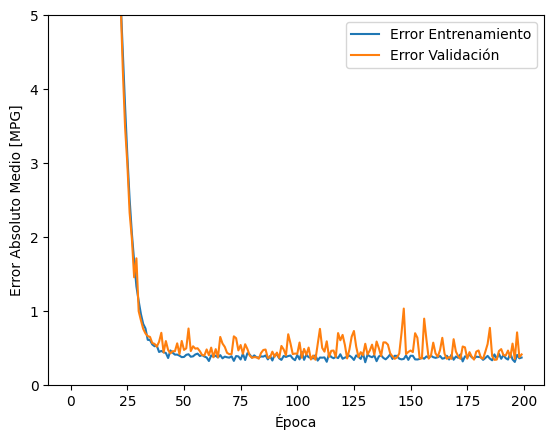

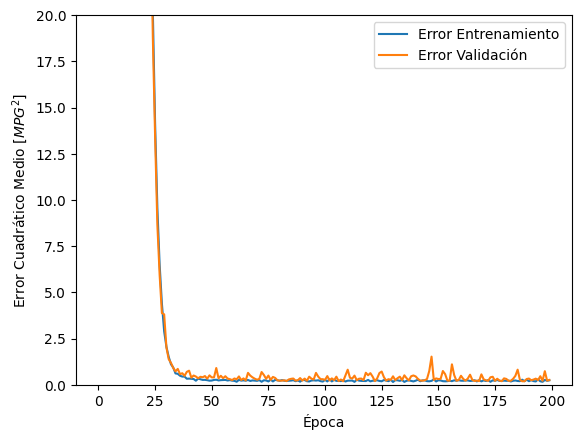

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Época')
  plt.ylabel('Error Absoluto Medio [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Error Entrenamiento')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Error Validación')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Época')
  plt.ylabel('Error Cuadrático Medio [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Error Entrenamiento')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Error Validación')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

5/5 - 0s - 9ms/step - loss: 0.1984 - mae: 0.3609 - mse: 0.1984


detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



................................................................................

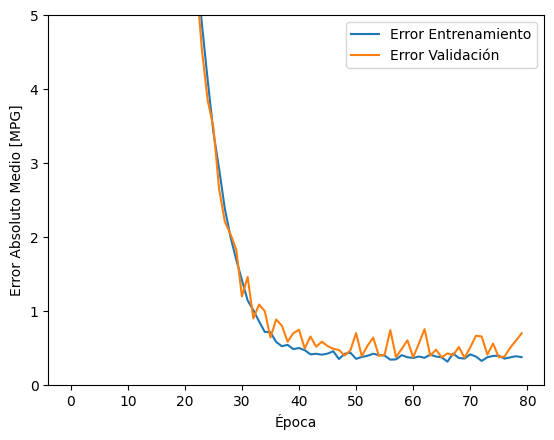

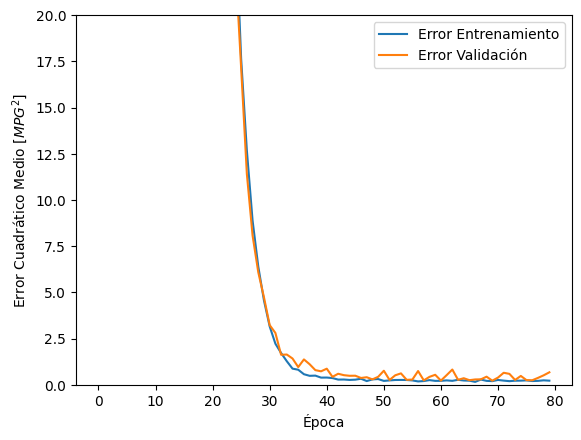

5/5 - 0s - 9ms/step - loss: 0.5376 - mae: 0.6265 - mse: 0.5376


In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)


## Guardamos el modelo

In [ ]:

def get_file_size(file_path):
  return os.path.getsize(file_path)

KERAS_MODEL_NAME = "tf_model_temp.h5"
model.save(KERAS_MODEL_NAME)
print("El tamaño del modelo TensorFlow es de %d bytes" % get_file_size(KERAS_MODEL_NAME))


El tamaño del modelo TensorFlow es de 61544 bytes


# Prueba
## Haciendo predicciones

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


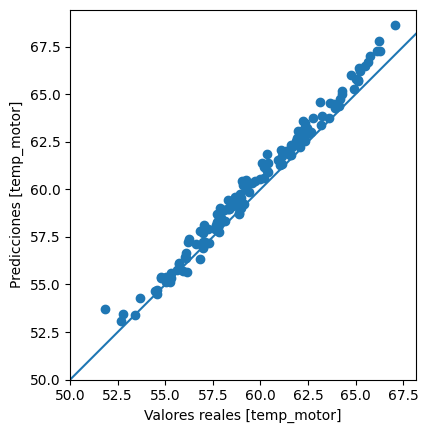

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Valores reales [temp_motor]')
plt.ylabel('Predicciones [temp_motor]')
plt.axis('equal')
plt.axis('square')
plt.xlim([50,plt.xlim()[1]])
plt.ylim([50,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


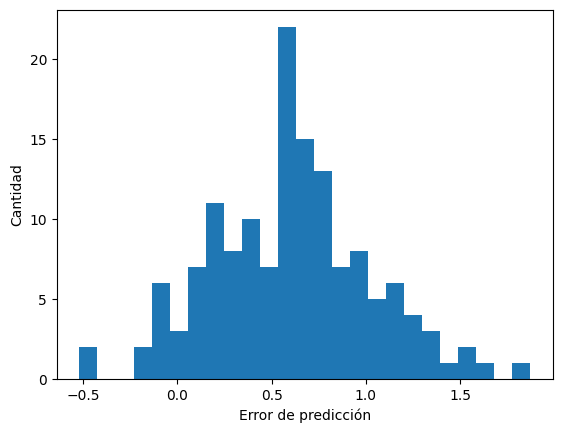

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Error de predicción")
_ = plt.ylabel("Cantidad")


# TensorFlow Lite
## Conversión del modelo a TFLite

In [ ]:
TF_LITE_MODEL_NAME = "tflite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
open(TF_LITE_MODEL_NAME, "wb").write(tflite_model)
print("El tamaño del modelo TensorFlow Lite es de %d bytes" % get_file_size(TF_LITE_MODEL_NAME))

Saved artifact at '/tmp/tmpuy3urreo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139334478650000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334478651728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334478648464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475567120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475566352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475568656: TensorSpec(shape=(), dtype=tf.resource, name=None)
El tamaño del modelo TensorFlow Lite es de 19548 bytes


## Usando el modelo de TF Lite
Verificaremos si estamos perdiendo precisión o no usando el modelo TF Lte
El modelo de TF Lite está en formato flatbuffer. Necesitamos llevarlo a un formato protocol buffer para hacer las inferemcias

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape: ', input_details[0]['shape'])
print('Input Type: ', input_details[0]['dtype'])
print('Output Shape: ', output_details[0]['shape'])
print('Output Type: ', output_details[0]['dtype'])


Input Shape:  [1 2]
Input Type:  <class 'numpy.float32'>
Output Shape:  [1 1]
Output Type:  <class 'numpy.float32'>


In [ ]:
test_dataset.tail()

,temp_aire,hum_relativa
701,19.9,86.0
705,18.8,91.0
707,18.0,90.0
708,19.3,84.0
719,22.9,70.0


In [ ]:
import numpy as np
interpreter.resize_tensor_input(input_details[0]['index'], (144, 2))
interpreter.resize_tensor_input(output_details[0]['index'], (144, 1))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape: ', input_details[0]['shape'])
print('Input Type: ', input_details[0]['dtype'])
print('Output Shape: ', output_details[0]['shape'])
print('Output Type: ', output_details[0]['dtype'])
normed_test_data = np.float32(normed_test_data)
interpreter.set_tensor(input_details[0]['index'], normed_test_data)
interpreter.invoke()
y_pred = interpreter.get_tensor(output_details[0]['index'])

mae = keras.metrics.MeanAbsoluteError()
mae.update_state(test_labels, y_pred)


mse = keras.metrics.MeanSquaredError()
mse.update_state(test_labels, y_pred)
print('mae: {0} - mse: {1}'.format(mae.result(), mse.result()))



Input Shape:  [144   2]
Input Type:  <class 'numpy.float32'>
Output Shape:  [144   1]
Output Type:  <class 'numpy.float32'>
mae: 0.3736100494861603 - mse: 0.22496025264263153


## Quantization
Reducimos el numero de bits para los pesos y las activaciones

In [ ]:
QUANT_MODEL_NAME = "quant_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
#tf_lite_converter.target_spec.support_types = [tf.float16]
tflite_model = tf_lite_converter.convert()
open(QUANT_MODEL_NAME, "wb").write(tflite_model)
print("El tamaño del modelo TensorFlow Lite Quantification es de %d bytes" % get_file_size(QUANT_MODEL_NAME))


Saved artifact at '/tmp/tmpl5bgf3t6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139334478650000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334478651728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334478648464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475567120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475566352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475568656: TensorSpec(shape=(), dtype=tf.resource, name=None)
El tamaño del modelo TensorFlow Lite Quantification es de 8056 bytes


In [ ]:
interpreter = tf.lite.Interpreter(model_path = QUANT_MODEL_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape: ', input_details[0]['shape'])
print('Input Type: ', input_details[0]['dtype'])
print('Output Shape: ', output_details[0]['shape'])
print('Output Type: ', output_details[0]['dtype'])


Input Shape:  [1 2]
Input Type:  <class 'numpy.float32'>
Output Shape:  [1 1]
Output Type:  <class 'numpy.float32'>


In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (144, 2))
interpreter.resize_tensor_input(output_details[0]['index'], (144, 1))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape: ', input_details[0]['shape'])
print('Input Type: ', input_details[0]['dtype'])
print('Output Shape: ', output_details[0]['shape'])
print('Output Type: ', output_details[0]['dtype'])
normed_test_data = np.float32(normed_test_data)
interpreter.set_tensor(input_details[0]['index'], normed_test_data)
interpreter.invoke()
y_pred = interpreter.get_tensor(output_details[0]['index'])

mae = keras.metrics.MeanAbsoluteError()
mae.update_state(test_labels, y_pred)


mse = keras.metrics.MeanSquaredError()
mse.update_state(test_labels, y_pred)
print('mae: {0} - mse: {1}'.format(mae.result(), mse.result()))

Input Shape:  [144   2]
Input Type:  <class 'numpy.float32'>
Output Shape:  [144   1]
Output Type:  <class 'numpy.float32'>
mae: 0.3712669610977173 - mse: 0.22225549817085266


## Optimizacion de SPARSITY


In [ ]:
SPARSITY_MODEL_NAME = "sparsity_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
tflite_model = tf_lite_converter.convert()
open(SPARSITY_MODEL_NAME, "wb").write(tflite_model)
print("El tamaño del modelo TensorFlow Lite Quantification es de %d bytes" % get_file_size(SPARSITY_MODEL_NAME))

Saved artifact at '/tmp/tmp1daaycy_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139334478650000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334478651728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334478648464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475567120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475566352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139334475568656: TensorSpec(shape=(), dtype=tf.resource, name=None)
El tamaño del modelo TensorFlow Lite Quantification es de 19620 bytes


In [ ]:
interpreter = tf.lite.Interpreter(model_path = SPARSITY_MODEL_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape: ', input_details[0]['shape'])
print('Input Type: ', input_details[0]['dtype'])
print('Output Shape: ', output_details[0]['shape'])
print('Output Type: ', output_details[0]['dtype'])

Input Shape:  [1 2]
Input Type:  <class 'numpy.float32'>
Output Shape:  [1 1]
Output Type:  <class 'numpy.float32'>


In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (144, 2))
interpreter.resize_tensor_input(output_details[0]['index'], (144, 1))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape: ', input_details[0]['shape'])
print('Input Type: ', input_details[0]['dtype'])
print('Output Shape: ', output_details[0]['shape'])
print('Output Type: ', output_details[0]['dtype'])
normed_test_data = np.float32(normed_test_data)
interpreter.set_tensor(input_details[0]['index'], normed_test_data)
interpreter.invoke()
y_pred = interpreter.get_tensor(output_details[0]['index'])

mae = keras.metrics.MeanAbsoluteError()
mae.update_state(test_labels, y_pred)


mse = keras.metrics.MeanSquaredError()
mse.update_state(test_labels, y_pred)
print('mae: {0} - mse: {1}'.format(mae.result(), mse.result()))

Input Shape:  [144   2]
Input Type:  <class 'numpy.float32'>
Output Shape:  [144   1]
Output Type:  <class 'numpy.float32'>
mae: 0.3736354112625122 - mse: 0.2249787449836731


## Convertir en un array en C
Muchas plataformas de microcontroladores no son compatibles con el sistema de archivos nativo. El la forma más sencilla de usar un modelo de tu programa es incluirlo como un array en C y compilarlo en tu programa.

El siguiente comando de Unix generará un archivo de origen C que contiene las Modelo de LiteRT como un array char:

In [ ]:
!apt-get -qq install xxd
!xxd -i tf_lite_model_temp.tflite > esp32_model2.cc

xxd: tf_lite_f16_model.tflite: No such file or directory
